In [118]:
# Import Statements
# Standard Library Imports
import os
import sys

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Local Imports

# Load and Preprocess Data

## Transcription Factor Targets

In [119]:
tf_fold_change = pd.read_excel(os.path.join("..", "data", "tfoe", "13059_2014_502_MOESM1_ESM.xlsx"), 
                               sheet_name = "SupplementaryTableS2", 
                               usecols="A,E:HB",
                               header=0,
                               index_col=0,
                               skiprows=8).drop("ID")

In [120]:
tf_p_value = pd.read_excel(os.path.join("..", "data", "tfoe", "13059_2014_502_MOESM1_ESM.xlsx"),
                           sheet_name = "SupplementaryTableS2",
                           usecols="A,HC:OZ",
                           header=0,
                           index_col=0,
                           skiprows=8).drop("ID")

# Pandas adds a ".1" suffix due to the repeats (the earlier FC columns, even though those aren't included in the output)
tf_p_value.columns = tf_p_value.columns.str.replace(".1", "")

In [121]:
# For each TF, get the genes which are > 1 in fold change and < 0.01 in p-value
tf_targets = {}
for tf in tf_fold_change.columns:
    target_list = list(tf_fold_change.index[(np.abs(tf_fold_change.loc[:,tf]) > 1.) & (tf_p_value.loc[:,tf] < 0.01)])
    if tf in target_list:
        target_list.remove(tf)
    tf_targets[tf] = target_list

## Phosphorylation Targets

In [122]:
kinase_to_rv = {
    "PknB": "Rv0014c",
    "PknD": "Rv0931c",
    "PknE": "Rv1743",
    "PknF": "Rv1746",
    "PknG": "Rv0410c",
    "PknH": "Rv1266c",
    "PknI": "Rv2014c",
    "PknJ": "Rv2088",
    "PknK": "Rv3080c",
    "PknL": "Rv2176"
}

rv_to_kinase = {v: k for k, v in kinase_to_rv.items()}

In [123]:
phosphorylation_targets = {}
for kinase in kinase_to_rv:
    kinase_sheet = pd.read_excel(os.path.join("..", "data", "phosphorylation", "41564_2022_1313_MOESM3_ESM.xlsx"),
                                 sheet_name = kinase,
                                 usecols="D,F",
                                 header=0)
    target_genes = np.unique(kinase_sheet["Rv Number"].values)
    phosphorylation_targets[kinase] = target_genes

## Expression Data

### Compendia RNA-seq

In [163]:
compendia_expr = pd.read_csv(os.path.join("..", "data", "compendia", "log_tpm_norm.csv"), index_col=0).transpose()
compendia_genes = compendia_expr.columns
compendia_expr.index.names = ["Sample"]
compendia_expr = compendia_expr.reset_index()
compendia_expr.rename_axis(None, axis=1, inplace=True)
compendia_metadata = pd.read_csv(os.path.join("..", "data", "compendia", "metadata_final.csv"), index_col=0)[
    ["Run", "SRAStudy", "BioProject", "ProjectID", "project", "condition", 
     "Biological Replicates", "reference_condition", "full_name"]
].reindex(compendia_expr["Sample"])
# Since the data is log2(fold-change) from the reference condition, we need to remove the reference condition (since they will average to 0)
compendia_metadata = compendia_metadata[~compendia_metadata["condition"].isin(compendia_metadata["reference_condition"].unique())]
compendia_expr = compendia_expr[compendia_expr["Sample"].isin(compendia_metadata.index)]

In [168]:
# Get the mean expression of each gene in each condition
compendia_expr["full_name"] = compendia_metadata["full_name"]
#compendia_expr.drop("Sample", axis=1, inplace=False).groupby("full_name").mean()


In [173]:
compendia_expr['full_name']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
642    NaN
643    NaN
644    NaN
645    NaN
646    NaN
Name: full_name, Length: 514, dtype: object

In [139]:
for group, df in compendia_expr.groupby("full_name"):
    print(group)
    print(df)

### Kinase Perturbation RNA-seq

In [75]:
perturb_expr = pd.read_csv(os.path.join("..", "data", "phosphorylation", "GSE195959_Expression.MTB.GeneData.csv"), index_col=0).drop("GrowthPhase", axis=1)
# Convert from RPKM to TPM, then take the log base 2 (adding noise to avoid log(0))
perturb_expr = np.log2((perturb_expr.div(perturb_expr.sum(axis=1), axis=0) * 1e6)+1e-10)
# Now subtract the mean of the control samples
perturb_expr = perturb_expr.subtract(perturb_expr[perturb_expr.index.str.startswith("WT")].mean(axis=0), axis=1)
# Drop the control samples
perturb_expr = perturb_expr.loc[~perturb_expr.index.str.startswith("WT")]
perturb_genes = perturb_expr.columns

## Combined Targets
Combine the TF and Kinase targets to get dictionaries of gene to TF, and gene to Kinase

In [97]:
# Get genes found in both the kinase perturbation and compendia datasets
total_gene_list = np.intersect1d(compendia_genes, perturb_genes)

# Dictionaries for the results
gene_to_tf = {}
tf_to_kinase = {}

for gene in total_gene_list:
    for tf in tf_targets:
        if gene in tf_targets[tf]:
            if gene not in gene_to_tf:
                gene_to_tf[gene] = [tf]
            else:
                gene_to_tf[gene].append(tf)

for tf in tf_targets:
    for kinase in phosphorylation_targets:
        if tf in phosphorylation_targets[kinase]:
            if tf not in tf_to_kinase:
                tf_to_kinase[tf] = [kinase_to_rv[kinase]]
            else:
                tf_to_kinase[tf].append(kinase_to_rv[kinase])
            
            

## Fitting Mixed Effects Model

In [99]:
len(tf_to_kinase)

96

206

In [108]:
values, counts = np.unique(compendia_metadata["full_name"], return_counts=True)

In [109]:
values

array(['AX:AX_10_MIC', 'AX:AX_30_MIC', 'AX:QZ_10_MIC', 'AX:QZ_30_MIC',
       'ITM_04:00h_clinic_ctrl', 'ITM_04:06h_clinic_DMSO',
       'ITM_04:06h_clinic_delam', 'ITM_04:06h_h37rv_DMSO',
       'ITM_04:06h_h37rv_delam', 'ITM_04:24h_clinic_DMSO',
       'ITM_04:24h_clinic_delam', 'ITM_04:24h_h37rv_DMSO',
       'ITM_04:24h_h37rv_delam', 'JSF:JSF_2019', 'JSF:JSF_2026',
       'MTS1338:over_expression', 'PAS:treated',
       'THP-1:24h_THP_B_enriched', 'aminoimidazoles:02h_treated',
       'aminoimidazoles:24h_treated', 'antibiotic:ctrl_24h',
       'antibiotic:izd_4h', 'base:wt_glu_24', 'base:wt_llac_24',
       'base:wt_llac_6', 'base:wt_pyr_24', 'base:wt_pyr_6',
       'biofilm:biofilm', 'btz043:0_days_.006', 'btz043:1_days_.006',
       'btz043:1_days_control', 'clarithromycin:1_days_control',
       'cnpB:del', 'csoR:ko', 'dap:0_days_25', 'dap:1_days_25',
       'dap:1_days_control', 'degradosome:PNPase_ko',
       'degradosome:Rnase_E_ko', 'degradosome:mutant_rnj',
       'degrado

(array([ 1.,  0., 74.,  0., 83.,  0., 25.,  0.,  2.,  1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

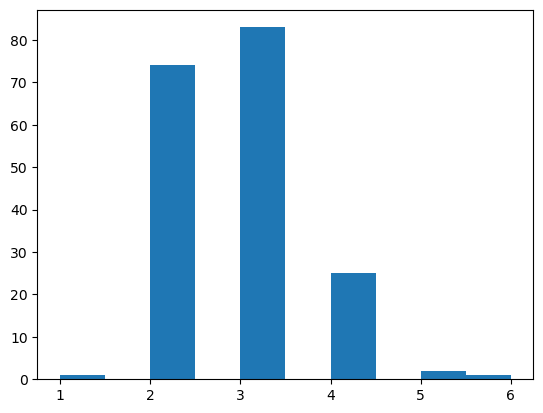

In [110]:
plt.hist(counts)

In [111]:
len(counts)

186